In [1]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [2]:
from typing import List, Tuple

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import Tensor
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch.nn.functional as F

In [4]:
import pandas as pd

In [5]:
import re

In [6]:
from tqdm import tqdm

In [7]:
model_name = "Qwen/Qwen2.5-1.5B"

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

In [9]:
def generate_pattern_sequence(pattern: list, seq_len: int, pattern_padding: int = 0) -> np.ndarray:
    not_full_seq = pattern * int(seq_len / len(pattern))
    pattern_seq = np.array(pattern * pattern_padding + not_full_seq + pattern[:seq_len - len(not_full_seq)], dtype=int)
    return pattern_seq

In [10]:
def run_sequence_through_model(model, sequence) -> Tuple[Tensor, Tensor]:
    with torch.no_grad():
            outputs = model(sequence)
            logits = outputs.logits
            
    shifted_logits = logits[:, :-1, :].contiguous().squeeze(0)        
    predicts = torch.argmax(shifted_logits, dim=1).squeeze()
    return predicts, shifted_logits   

In [11]:
def test_sequence_shift(model, sequence: np.ndarray, shifts: list, test_seq_len: int) -> List[Tuple[float, float]]:
    test_seq_len = len(sequence) - 1 if test_seq_len >= len(sequence) else test_seq_len
    results = []
    for shift in tqdm(shifts):
        inputs_ids = torch.tensor(sequence + shift, dtype=torch.int32).unsqueeze(0)
        predicts, shifted_logits = run_sequence_through_model(model, inputs_ids)
        test_seq = inputs_ids[:, -test_seq_len:].contiguous().squeeze(0)
        shifted_inputs = inputs_ids[:, 1:].contiguous().squeeze(0)
        
        actual_log_probs = F.log_softmax(shifted_logits, dim=-1)[torch.arange(shifted_inputs.shape[0]), shifted_inputs]
        mean_log_likelyhood = actual_log_probs.mean().numpy()
        acc = (predicts[-test_seq_len:] == test_seq).sum().numpy() / test_seq_len
        median_dist = torch.median(predicts[-test_seq_len:] - test_seq).numpy()
        
        for matching_start in range(shifted_inputs.shape[0]):
            if (predicts[matching_start:] == shifted_inputs[matching_start:]).all():
                break
        
        results.append((acc, mean_log_likelyhood, median_dist, matching_start))
            
    return results

In [12]:
def plot_shift_test_results(results, shift_range, subplot_titles, height=1000, width=1800):
    fig = make_subplots(rows=len(subplot_titles), cols=1, subplot_titles=subplot_titles)
    for i in range(len(subplot_titles)):
        fig.add_trace(go.Scatter(x=shift_range, y=np.array([r[i] for r in results]), mode='lines'), row=i+1, col=1)
    # Update layout
    fig.update_layout(height=height, width=width, margin=dict(t=50, b=50, l=50, r=50))
    fig.update_xaxes(title_text='Index Shift', row=1, col=1)
    fig.update_xaxes(title_text='Index Shift', row=2, col=1)
    fig.update_xaxes(title_text='Index Shift', row=3, col=1)
    fig.update_xaxes(title_text='Index Shift', row=4, col=1)
    fig.update_yaxes(title_text='Accuracy', row=1, col=1)
    fig.update_yaxes(title_text='Log-Likelyhood', row=2, col=1)
    fig.update_yaxes(title_text='Median Error', row=3, col=1)
    fig.update_yaxes(title_text='Start of matching', row=4, col=1)
    # Show the figure
    fig.show()

In [13]:
def plot_sequence_prediction(factual_seq, predicted_seq, start_from_idx, height, width, indices_range=None, end_on_idx=-1, disable_fact=False):
    fig = go.Figure()
    x = np.arange(start_from_idx + 2, len(factual_seq) + 1)
    if not disable_fact:
        fig.add_trace(go.Scatter(x=x, y=factual_seq[start_from_idx:end_on_idx], mode='markers', marker=dict(size=10), name="Input"))
    fig.add_trace(go.Scatter(x=x, y=predicted_seq[start_from_idx:end_on_idx], mode='markers', marker=dict(size=8), name="Predicted"))
    fig.update_layout(height=height, width=width, margin=dict(t=50, b=50, l=50, r=50))
    fig.update_xaxes(title_text="Element's Index", range=[start_from_idx, len(factual_seq) if end_on_idx == -1 else end_on_idx])
    if indices_range:
        fig.update_yaxes(title_text="Token's Index", range=indices_range)
    else:
        fig.update_yaxes(title_text="Token's Index")
    fig.show()

In [14]:
def plot_log_prob(logits, factual_seq, height=400, width=1200):
    fig = go.Figure()
    x = np.arange(2, logits.shape[0] + 1)
    log_probs = F.log_softmax(logits, dim=-1)
    actual_log_probs = log_probs[torch.arange(logits.shape[0]), factual_seq[1:]].numpy()
    predicted_log_probs = log_probs.numpy().max(axis=1)
    fig.add_trace(go.Scatter(x=x, y=predicted_log_probs, mode='lines', line={'width': 6}, name="predicted token"))
    fig.add_trace(go.Scatter(x=x, y=actual_log_probs, mode='lines', line={'width': 3}, name="input token"))
    fig.update_layout(height=height, width=width, margin=dict(t=50, b=50, l=50, r=50))
    fig.update_xaxes(title_text="Element's Index", range=[1, len(factual_seq)])
    fig.update_yaxes(title_text="Log-Probability")
    fig.show()

In [15]:
def array_to_string(arr, sep=','):
    return sep.join(map(str, arr))

def find_valid_sequence_start(s):
    pattern = re.compile(r'(\d+(,\d+)*)\Z')
    match = pattern.search(s)
    if match:
        return match.start(1)
    return -1

def convert_substring_to_integers(substring):
    return list(map(int, substring.split(',')))

def find_start_match_position(predicted, factual):
    for i in range(len(factual)):
        if predicted[i:] == factual[i:]:
            return i

In [16]:
def string_to_integers(s):
    return [int(char) for char in s]

def plot_arrays(factual, predicts):
    trace1 = go.Scatter(
        x=list(range(len(factual))),
        y=factual,
        mode='markers',
        name='Factual',
        marker=dict(size=10)
    )

    trace2 = go.Scatter(
        x=list(range(len(factual) - len(predicts), len(factual))),
        y=predicts,
        mode='markers',
        name='Predicts',
        marker=dict(size=7)
    )

    layout = go.Layout(
        xaxis=dict(title='Index'),
        yaxis=dict(title='Value')
    )
    
    fig = go.Figure(data=[trace1, trace2], layout=layout)
    fig.show()


## Flat signal

In [51]:
zeros_str = array_to_string([0] * 256, '')

In [74]:
zero_str_logits = model(torch.tensor(tokenizer.encode(zeros_str), dtype=torch.int32).unsqueeze(0))

In [81]:
zero_str_predicted_idxs = torch.argmax(zero_str_logits.logits[:, :-1, :].contiguous().squeeze(0), dim=1).squeeze()

In [84]:
predicted_zeros_str = tokenizer.decode(zero_str_predicted_idxs)

In [85]:
zeros_str[1:] == predicted_zeros_str

True

In [86]:
flat_signal_str = array_to_string([0] * 256)

In [87]:
flat_signal_str_logits = model(torch.tensor(tokenizer.encode(flat_signal_str), dtype=torch.int32).unsqueeze(0))

In [90]:
flat_signal_str_predicted_idxs = torch.argmax(flat_signal_str_logits.logits[:, :-1, :].contiguous().squeeze(0), dim=1).squeeze()

In [91]:
predicted_flat_signal_str = tokenizer.decode(flat_signal_str_predicted_idxs)
predicted_flat_signal_str

'0 00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0'

## stable sinusoid

In [20]:
seq_len = 256

In [21]:
x = np.linspace(0, 2 * np.pi, 32, endpoint=False)
sinusoid = np.sin(x)

scaled_sinusoid = sinusoid * 10

integer_sinusoid = np.round(scaled_sinusoid).astype(int)
integer_sinusoid += 2000

sinusoid_pattern = integer_sinusoid.tolist()

In [22]:
sin_seq = generate_pattern_sequence(pattern=sinusoid_pattern, seq_len=seq_len, pattern_padding=2)

In [95]:
sin_str = array_to_string(sin_seq, sep='')

In [97]:
sin_str_logits = model(torch.tensor(tokenizer.encode(sin_str), dtype=torch.int32).unsqueeze(0)).logits

In [99]:
sin_str_predicted_idxs = torch.argmax(sin_str_logits[:, :-1, :].contiguous().squeeze(0), dim=1).squeeze()

In [100]:
predicted_sin_str = tokenizer.decode(sin_str_predicted_idxs)

In [104]:
len(predicted_sin_str)

1279

In [103]:
find_start_match_position(predicted_sin_str, sin_str[1:])

219

In [105]:
len(array_to_string(sinusoid_pattern, sep=''))

128

In [109]:
start = find_valid_sequence_start(predicted_sin_str)

In [132]:
factual_arr = string_to_integers(sin_str[1 + start:])
predicted_arr = string_to_integers(predicted_sin_str[start:])

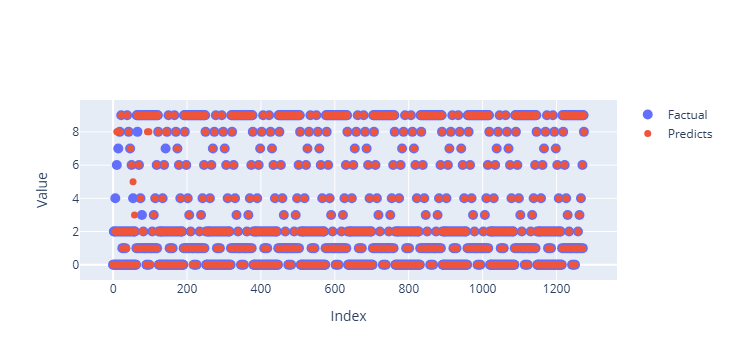

In [114]:
plot_arrays(factual=factual_arr, predicts=predicted_arr)

In [115]:
sin_str_2 = array_to_string(sin_seq)

In [116]:
sin_str_2_logits = model(torch.tensor(tokenizer.encode(sin_str_2), dtype=torch.int32).unsqueeze(0)).logits

In [117]:
sin_str_2_predicted_idxs = torch.argmax(sin_str_2_logits[:, :-1, :].contiguous().squeeze(0), dim=1).squeeze()

In [118]:
predicted_sin_str_2 = tokenizer.decode(sin_str_2_predicted_idxs)

In [119]:
start_2 = find_valid_sequence_start(predicted_sin_str_2)

In [122]:
predicted_2 = convert_substring_to_integers(predicted_sin_str_2[start_2:])

In [129]:
len_diff = len(sin_seq) - len(predicted_2)

In [130]:
(np.array(predicted_2) == np.array(sin_seq[len_diff:])).sum() / len(sin_seq)

0.9625

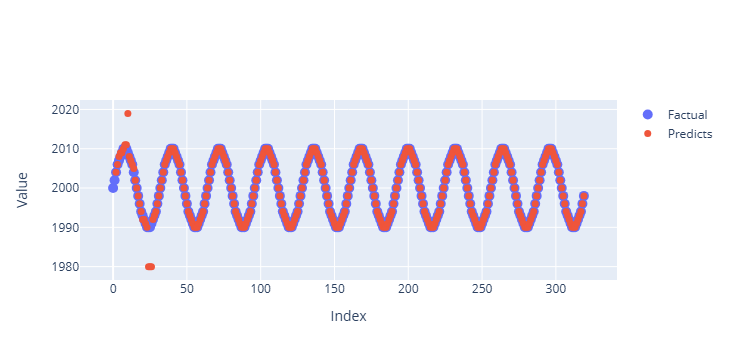

In [125]:
plot_arrays(factual=sin_seq, predicts=predicted_2[1:])

## Expanding sinusoid

In [23]:
aplituded_max = 100
periods = 7

t = np.linspace(0, periods * np.pi, seq_len, endpoint=True)
amplitude = np.linspace(1, aplituded_max, seq_len, endpoint=True)

sinusoid = np.sin(t) * amplitude
sinusoid_int = np.round(sinusoid).astype(int)

In [144]:
expand_sin_seq = (sinusoid_int + 200).tolist()

In [148]:
expand_sin_predicts, expand_sin_logits = run_sequence_through_model(model, torch.tensor(expand_sin_seq, dtype=torch.int32).unsqueeze(0))

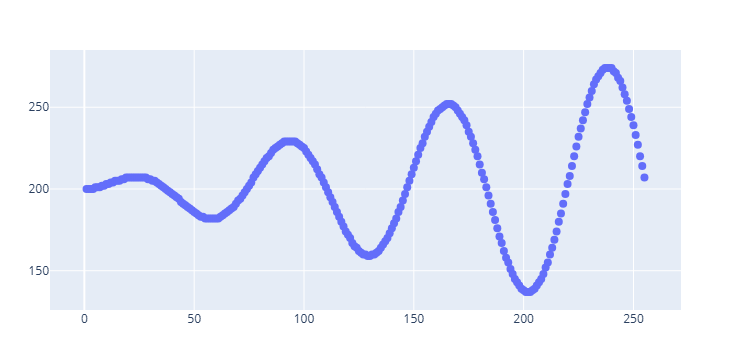

In [147]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(1, len(expand_sin_seq)), y=expand_sin_seq, mode='markers', marker=dict(size=8)))
fig.update_layout(height=200, width=800, margin=dict(t=50, b=50, l=50, r=50))
fig.show()

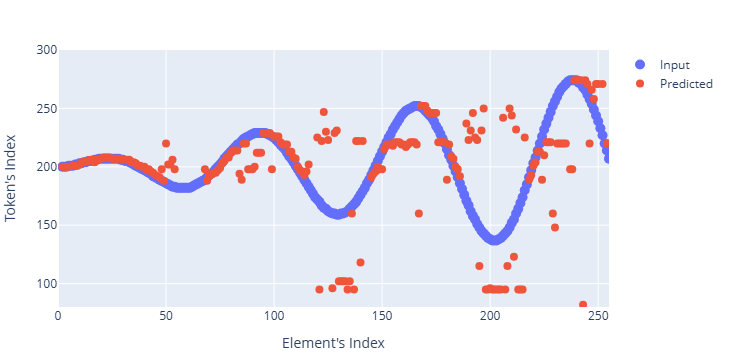

In [153]:
plot_sequence_prediction(factual_seq=expand_sin_seq[1:], predicted_seq=expand_sin_predicts, start_from_idx=0, indices_range=(80, 300), height=200, width=1000)

In [154]:
expand_sin_str = array_to_string(expand_sin_seq)

In [155]:
expand_sin_str_logits = model(torch.tensor(tokenizer.encode(expand_sin_str), dtype=torch.int32).unsqueeze(0)).logits

In [156]:
expand_sin_str_predicted_idxs = torch.argmax(expand_sin_str_logits[:, :-1, :].contiguous().squeeze(0), dim=1).squeeze()

In [157]:
predicted_expand_sin_str = tokenizer.decode(expand_sin_str_predicted_idxs)

In [164]:
start_2 = find_valid_sequence_start(predicted_expand_sin_str)

In [165]:
predicted_2 = convert_substring_to_integers(predicted_expand_sin_str[start_2:])

In [171]:
len_diff = len(expand_sin_seq) - len(predicted_2)
len_diff

1

In [172]:
(np.array(predicted_2) == np.array(expand_sin_seq[len_diff:])).sum() / len(expand_sin_seq[1:])

0.5803921568627451

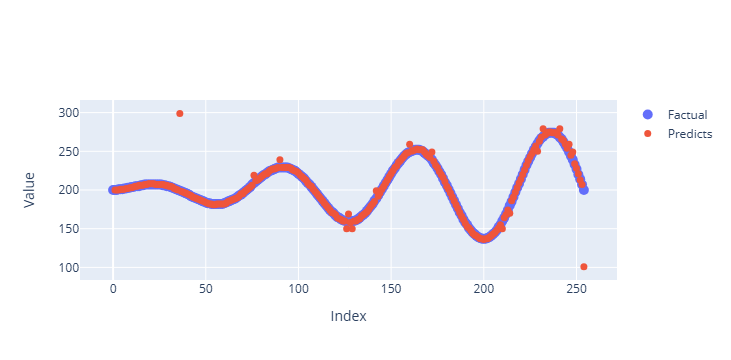

In [173]:
plot_arrays(factual=expand_sin_seq[1:], predicts=predicted_2[1:])

# Working with noise sequence

In [17]:
def plot_log_prob_with_noise(logits, base_seq, noise_indecies, plot_name, height=400, width=1200):
    fig = go.Figure()
    x = np.arange(2, logits.shape[0] + 1)
    log_probs = F.log_softmax(logits, dim=-1)
    base_log_probs = log_probs[torch.arange(logits.shape[0]), base_seq[1:]].numpy()
    predicted_log_probs = log_probs.numpy().max(axis=1)
    fig.add_trace(go.Scatter(x=x, y=predicted_log_probs, mode='lines', line={'width': 6}, name="Log-Probability of predicted token"))
    fig.add_trace(go.Scatter(x=x, y=base_log_probs, mode='lines', line={'width': 3}, name="Log-Probability of baseline token"))
    for idx in noise_indecies:
        fig.add_vline(x=idx, line_width=1, line_dash="dash", line_color="black")
    fig.update_layout(title_text=plot_name, title_font=dict(size=24), height=height, width=width, margin=dict(t=50, b=50, l=50, r=50))
    fig.update_xaxes(title_text="Element's Index", range=[1, len(base_seq)])
    fig.update_yaxes(title_text="Log-Probability")
    fig.show()

## Sinusoid with noise

In [24]:
sin_seq_orig = generate_pattern_sequence(pattern=sinusoid_pattern, seq_len=256, pattern_padding=2) + 200
sin_seq_noised = sin_seq_orig.copy()
np.random.seed(42)
noise_idxs = []
for i in range(-256, 0):
    if np.random.rand() <= 0.1:
        noise_idxs.append(len(sin_seq_orig) + i)
        sin_seq_noised[i] += np.random.randint(0, 201) - 100

In [107]:
sin_noiz_predicts, sin_noiz_logits = run_sequence_through_model(model, torch.tensor(sin_seq_noised, dtype=torch.int32).unsqueeze(0))

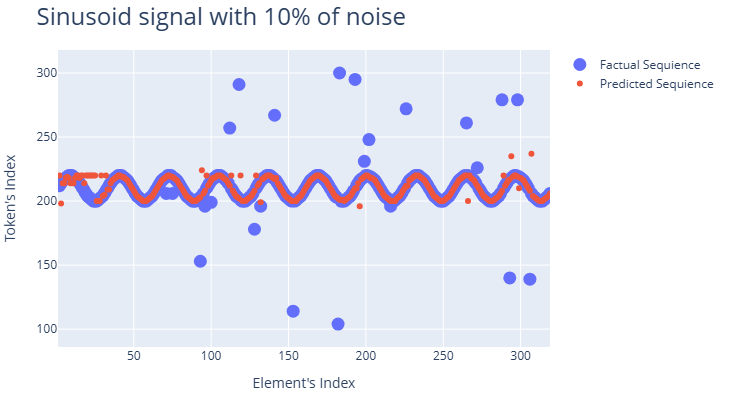

In [117]:
plot_sequence_prediction(factual_seq=sin_seq_noised[1:], predicted_seq=sin_noiz_predicts, start_from_idx=0, height=400, width=1600, plot_name="Sinusoid signal with 10% of noise")

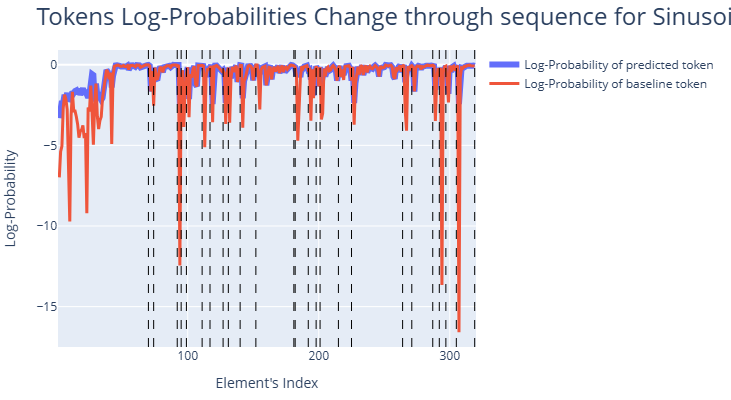

In [126]:
plot_log_prob_with_noise(logits=sin_noiz_logits, base_seq=sin_seq_orig, noise_indecies=noise_idxs, plot_name="Tokens Log-Probabilities Change through sequence for Sinusoid signal with noise", height=400, width=1700)

In [49]:
random_seeds = [42, 8800, 55, 3535]
noize_probs = [0.1, 0.2, 0.3]

In [50]:
shifts = np.arange(0, 100_000, 200)

In [27]:
key_map = {"acc": 0, "lkh": 1, "miderr": 2, "match": 3}

In [28]:
result_dict = {k: {} for k in key_map.keys()}

In [29]:
sin_seq_orig = generate_pattern_sequence(pattern=sinusoid_pattern, seq_len=256, pattern_padding=2)

In [30]:
for noize_prob in noize_probs:
    for k in key_map.keys():
         result_dict[k][f"noize prob={noize_prob}"] = np.zeros(len(shifts))
    for r_seed in random_seeds:
        sin_seq_noised = sin_seq_orig.copy()
        np.random.seed(r_seed)
        for i in range(-256, 0):
            if np.random.rand() <= noize_prob:
                sin_seq_noised[i] += np.random.randint(0, 21) - 10
        temp_result = test_sequence_shift(model, sequence=sin_seq_noised, shifts=shifts, test_seq_len=256)
        for k, v in key_map.items():
            result_dict[k][f"noize prob={noize_prob}"] += np.array([r[v] for r in temp_result])
    for k in key_map.keys():
        result_dict[k][f"noize prob={noize_prob}"] /= len(random_seeds)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [32:06<00:00,  9.63s/it]


In [ ]:
df = pd.DataFrame(result_dict['acc'])

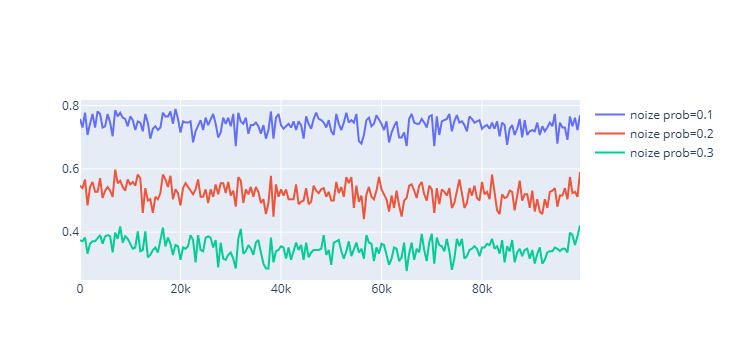

In [47]:
fig = go.Figure()
fig.add_traces(go.Scatter(x=shifts, y = df['noize prob=0.1'], mode = 'lines', name='noize prob=0.1'))
fig.add_traces(go.Scatter(x=shifts, y = df['noize prob=0.2'], mode = 'lines', name='noize prob=0.2'))
fig.add_traces(go.Scatter(x=shifts, y = df['noize prob=0.3'], mode = 'lines', name='noize prob=0.3'))
fig.show()

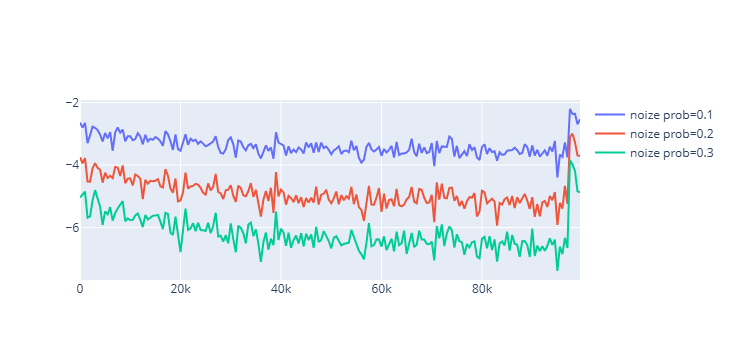

In [45]:
df = pd.DataFrame(result_dict['lkh'])
fig = go.Figure()
fig.add_traces(go.Scatter(x=shifts, y = df['noize prob=0.1'], mode = 'lines', name='noize prob=0.1'))
fig.add_traces(go.Scatter(x=shifts, y = df['noize prob=0.2'], mode = 'lines', name='noize prob=0.2'))
fig.add_traces(go.Scatter(x=shifts, y = df['noize prob=0.3'], mode = 'lines', name='noize prob=0.3'))
fig.show()